In [22]:
# Library Setup
from typing import List
from itertools import chain
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Matplotlib Setup
%matplotlib inline

# Read Images
winter_rgb = cv2.imread('assets/winter.png')
winter_gray = cv2.imread('assets/winter.png', 0)

flower_rgb = cv2.imread('assets/flower.jpeg')
flower_gray = cv2.imread('assets/flower.jpeg', 0)

sudoku_rgb = cv2.imread('assets/sudoku.jpg')
sudoku_gray = cv2.imread('assets/sudoku.jpg', 0)

origami_rgb = cv2.imread('assets/origami.jpg')
origami_gray = cv2.imread('assets/origami.jpg', 0)

In [23]:
# Some Auxiliary Functions
def plot_figure(image_list: List[np.ndarray], title_list: List[str], height, width):
    assert len(image_list) == len(title_list)
    for i in range(len(image_list)):
        plt.subplot(height, width, i + 1), plt.imshow(image_list[i], 'gray')
        plt.title(title_list[i])
        plt.xticks([]), plt.yticks([])
    plt.show()

# Thresholding
## Fixed Thresholding: Binary

In [24]:
def thresholds(img, threshold=120, maxval=255):
    ret, thresh1 = cv2.threshold(img, threshold, maxval, cv2.THRESH_BINARY)
    ret, thresh2 = cv2.threshold(img, threshold, maxval, cv2.THRESH_BINARY_INV)
    ret, thresh3 = cv2.threshold(img, threshold, maxval, cv2.THRESH_TRUNC)
    ret, thresh4 = cv2.threshold(img, threshold, maxval, cv2.THRESH_TOZERO)
    ret, thresh5 = cv2.threshold(img, threshold, maxval, cv2.THRESH_TOZERO_INV)
    
    titles = ['Original Image', 'THRESH_BINARY', 'THRESH_BINARY_INV', 'THRESH_TRUNC', 'THRESH_TOZERO', 'THRESH_TOZERO_INV']
    images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
    plot_figure(images, titles, 2, 3)

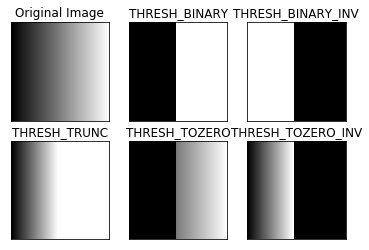

In [25]:
# Gradient Image 

x = np.linspace(0, 255, 100)
gradient = np.tile(x, (100, 1))

thresholds(gradient)

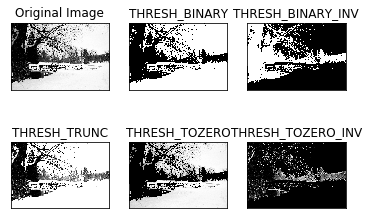

In [26]:
# Winter Image
thresholds(winter_gray)

## Fixed Thresholding - Custom

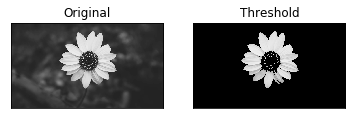

In [27]:
# Create a mask then do element-wise multiplication
result = (flower_gray > 150) * flower_gray

plot_figure([flower_gray, result], ['Original', 'Threshold'], 2, 2)

## Histograms

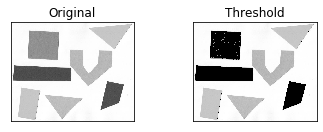

In [28]:
####   MY CODE   ####
#Create a mask then do element-wise multiplication

result = (origami_gray > 150) * origami_gray

plot_figure([origami_gray, result], ['Original', 'Threshold'], 2, 2)

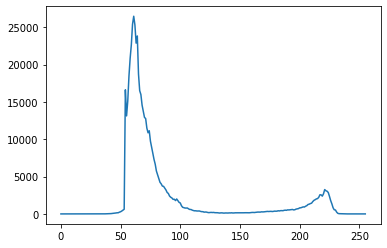

In [29]:
# find frequency of pixels in range 0-255
histr = cv2.calcHist([flower_gray], [0], None, [256], [0, 256])
plt.plot(histr)
plt.show()

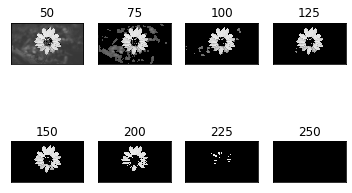

In [30]:
thresholds = [50, 75, 100, 125, 150, 200, 225, 250]

images = [(flower_gray > i) * flower_gray for i in  thresholds]
titles = [str(i) for i in thresholds]
plot_figure(images, titles, 2, 4)

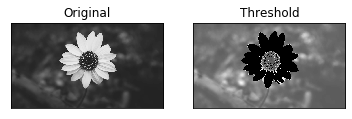

In [31]:
result = (flower_gray < 150) * (flower_gray > 45) * flower_gray

plot_figure([flower_gray, result], ['Original', 'Threshold'], 2, 2)

## Histogram - P-TILE 

Threshold value is: 155


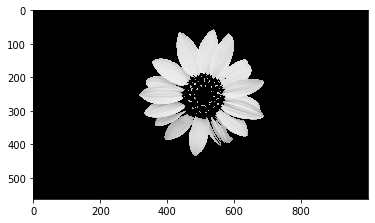

In [32]:
percentage = 0.875
val_list = list(chain.from_iterable(flower_gray))
val_list.sort()
threshold = val_list[int(len(val_list) * percentage)]
print(f'Threshold value is: {threshold}')
result = (flower_gray > threshold) * flower_gray
plt.imshow(result, 'gray')
plt.show()

## Adaptive Thresholding

In [33]:
def adaptive_thresholds(image):
    # Normal Threshold
    ret, th1 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    # threshold value is the mean of neighbourhood area.
    th2 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    # threshold value is the weighted sum of neighbourhood values where weights are a gaussian window.
    th3 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    titles = [
        'Original Image',
        'Global Thresholding (v = 127)',
        'Adaptive Mean Thresholding', 
        'Adaptive Gaussian Thresholding'
             ]

    images = [image, th1, th2, th3]
    plot_figure(images, titles, 2, 2)

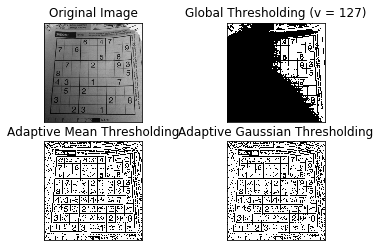

In [34]:
# Original
adaptive_thresholds(sudoku_gray)

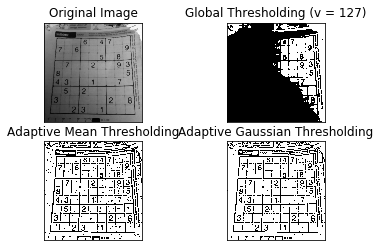

In [35]:
# With Blur
adaptive_thresholds(cv2.medianBlur(sudoku_gray, 5))

152


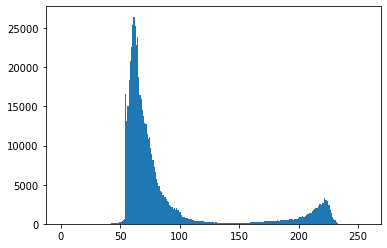

In [36]:
def balanced_hist_thresholding(b):
    # Starting point of histogram
    i_s = np.min(np.where(b[0]>0))
    # End point of histogram
    i_e = np.max(np.where(b[0]>0))
    # Center of histogram
    i_m = (i_s + i_e)//2
    # Left side weight
    w_l = np.sum(b[0][0:i_m+1])
    # Right side weight
    w_r = np.sum(b[0][i_m+1:i_e+1])
    # Until starting point not equal to endpoint
    while (i_s != i_e):
        # If right side is heavier
        if (w_r > w_l):
            # Remove the end weight
            w_r -= b[0][i_e]
            i_e -= 1
            # Adjust the center position and recompute the weights
            if ((i_s+i_e)//2) < i_m:
                w_l -= b[0][i_m]
                w_r += b[0][i_m]
                i_m -= 1
        else:
            # If left side is heavier, remove the starting weight
            w_l -= b[0][i_s]
            i_s += 1
            # Adjust the center position and recompute the weights
            if ((i_s+i_e)//2) >= i_m:
                w_l += b[0][i_m+1]
                w_r -= b[0][i_m+1]
                i_m += 1
    return i_m

b1 = plt.hist(flower_gray.ravel(),256,[0,256])
thresh_value = balanced_hist_thresholding(b1)
print(thresh_value)

## Otsu Thresholding
In global thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically.

Consider an image with only two distinct image values (bimodal image), where the histogram would only consist of two peaks. A good threshold would be in the middle of those two values. Similarly, Otsu's method determines an optimal global threshold value from the image histogram.

The main idea is to find the threshold that minimizes the weighted within-class variance.

$$\sigma_w^2(t) = q_1(t) * \sigma_1^2(t) + q_2(t) *\sigma_2^2(t)$$
Where
* $t$: is the current threshold
* $\sigma_w^2(t)$: is the weighted within class variance for the threshold $t$
* $\sigma_1^2(t)$: is the variance of region 1
* $\sigma_2^2(t)$: is the variance of region 2
* $q_1(t)$: is the weight of region 1
* $q_2(t)$: is the weight of region 2

$$q_1(t) = \sum_{i=1}^t P(i)$$
$$q_2(t) = \sum_{i=t+1}^l P(i)$$
where
* $P(i)$: is the value of the histogram at the bin $i$
* $l$: is the number of bins in the histogram

Now, Lets calculate the variance

$$\mu_1(t) = \frac{1}{q_1(t)} \sum_{i=1}^t i*P(i)$$
$$\mu_2(t) = \frac{1}{q_2(t)} \sum_{i=t+1}^l i*P(i)$$

Finally, the variance

$$\sigma_1^2(t) = \sum_{i=1}^t (i - \mu_1(t))^2 \frac{P(i)}{q_1(t)}$$
$$\sigma_2^2(t) = \sum_{i=t+1}^l (i - \mu_2(t))^2 \frac{P(i)}{q_2(t)}$$
What to do now?
Try every $t$ until you find the minimum $\sigma_w^2$

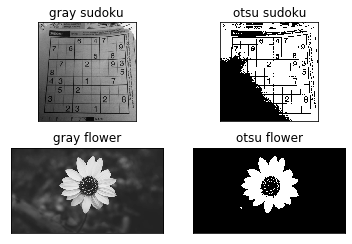

In [66]:
ret1, new_flower = cv2.threshold(flower_gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret2, new_sudoku = cv2.threshold(sudoku_gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_figure([sudoku_gray, new_sudoku, flower_gray, new_flower],
            ['gray sudoku', 'otsu sudoku', 'gray flower', 'otsu flower'], 2, 2)

In [77]:
import cv2
import numpy as np
#winter_rgb = cv2.imread('assets/winter.png')
winter_gray = cv2.imread('assets/winter.png', 0)
blur_img = cv2.GaussianBlur(winter_gray,(5,5),0)

hist = cv2.calcHist([blur_img],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.sum()

# numpy.cumsum(a, axis=None, dtype=None, out=None)
#return the cumulative sum of the elements along a given axis.

#CDF:
Q = hist_norm.cumsum()

#make array of 256 bins Array=[0,1,2,3,......255]
bins = np.arange(256)
#arrayt=[]
for t in range(256):
    # find otsu's threshold value with OpenCV function
    ret, otsu = cv2.threshold(blur_img,0,t,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #arrayt=arrayt.append((t))
    #array_t=np.append(array_t)
    print('t',t,'otsu',otsu,'ret',ret)
    t=t+1
print('array_t',arrayt)


t 0 otsu [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] ret 134.0
t 1 otsu [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]] ret 134.0
t 2 otsu [[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]] ret 134.0
t 3 otsu [[0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]] ret 134.0
t 4 otsu [[0 0 0 ... 4 4 4]
 [0 0 0 ... 4 4 4]
 [0 0 0 ... 4 4 4]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]] ret 134.0
t 5 otsu [[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]] ret 134.0
t 6 otsu [[0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]] ret 134.0
t 7 otsu [[0 0 0 ... 7 7 7]

t 52 otsu [[ 0  0  0 ... 52 52 52]
 [ 0  0  0 ... 52 52 52]
 [ 0  0  0 ... 52 52 52]
 ...
 [52 52 52 ... 52 52 52]
 [52 52 52 ... 52 52 52]
 [52 52 52 ... 52 52 52]] ret 134.0
t 53 otsu [[ 0  0  0 ... 53 53 53]
 [ 0  0  0 ... 53 53 53]
 [ 0  0  0 ... 53 53 53]
 ...
 [53 53 53 ... 53 53 53]
 [53 53 53 ... 53 53 53]
 [53 53 53 ... 53 53 53]] ret 134.0
t 54 otsu [[ 0  0  0 ... 54 54 54]
 [ 0  0  0 ... 54 54 54]
 [ 0  0  0 ... 54 54 54]
 ...
 [54 54 54 ... 54 54 54]
 [54 54 54 ... 54 54 54]
 [54 54 54 ... 54 54 54]] ret 134.0
t 55 otsu [[ 0  0  0 ... 55 55 55]
 [ 0  0  0 ... 55 55 55]
 [ 0  0  0 ... 55 55 55]
 ...
 [55 55 55 ... 55 55 55]
 [55 55 55 ... 55 55 55]
 [55 55 55 ... 55 55 55]] ret 134.0
t 56 otsu [[ 0  0  0 ... 56 56 56]
 [ 0  0  0 ... 56 56 56]
 [ 0  0  0 ... 56 56 56]
 ...
 [56 56 56 ... 56 56 56]
 [56 56 56 ... 56 56 56]
 [56 56 56 ... 56 56 56]] ret 134.0
t 57 otsu [[ 0  0  0 ... 57 57 57]
 [ 0  0  0 ... 57 57 57]
 [ 0  0  0 ... 57 57 57]
 ...
 [57 57 57 ... 57 57 57]
 [57 

t 106 otsu [[  0   0   0 ... 106 106 106]
 [  0   0   0 ... 106 106 106]
 [  0   0   0 ... 106 106 106]
 ...
 [106 106 106 ... 106 106 106]
 [106 106 106 ... 106 106 106]
 [106 106 106 ... 106 106 106]] ret 134.0
t 107 otsu [[  0   0   0 ... 107 107 107]
 [  0   0   0 ... 107 107 107]
 [  0   0   0 ... 107 107 107]
 ...
 [107 107 107 ... 107 107 107]
 [107 107 107 ... 107 107 107]
 [107 107 107 ... 107 107 107]] ret 134.0
t 108 otsu [[  0   0   0 ... 108 108 108]
 [  0   0   0 ... 108 108 108]
 [  0   0   0 ... 108 108 108]
 ...
 [108 108 108 ... 108 108 108]
 [108 108 108 ... 108 108 108]
 [108 108 108 ... 108 108 108]] ret 134.0
t 109 otsu [[  0   0   0 ... 109 109 109]
 [  0   0   0 ... 109 109 109]
 [  0   0   0 ... 109 109 109]
 ...
 [109 109 109 ... 109 109 109]
 [109 109 109 ... 109 109 109]
 [109 109 109 ... 109 109 109]] ret 134.0
t 110 otsu [[  0   0   0 ... 110 110 110]
 [  0   0   0 ... 110 110 110]
 [  0   0   0 ... 110 110 110]
 ...
 [110 110 110 ... 110 110 110]
 [110 11

t 159 otsu [[  0   0   0 ... 159 159 159]
 [  0   0   0 ... 159 159 159]
 [  0   0   0 ... 159 159 159]
 ...
 [159 159 159 ... 159 159 159]
 [159 159 159 ... 159 159 159]
 [159 159 159 ... 159 159 159]] ret 134.0
t 160 otsu [[  0   0   0 ... 160 160 160]
 [  0   0   0 ... 160 160 160]
 [  0   0   0 ... 160 160 160]
 ...
 [160 160 160 ... 160 160 160]
 [160 160 160 ... 160 160 160]
 [160 160 160 ... 160 160 160]] ret 134.0
t 161 otsu [[  0   0   0 ... 161 161 161]
 [  0   0   0 ... 161 161 161]
 [  0   0   0 ... 161 161 161]
 ...
 [161 161 161 ... 161 161 161]
 [161 161 161 ... 161 161 161]
 [161 161 161 ... 161 161 161]] ret 134.0
t 162 otsu [[  0   0   0 ... 162 162 162]
 [  0   0   0 ... 162 162 162]
 [  0   0   0 ... 162 162 162]
 ...
 [162 162 162 ... 162 162 162]
 [162 162 162 ... 162 162 162]
 [162 162 162 ... 162 162 162]] ret 134.0
t 163 otsu [[  0   0   0 ... 163 163 163]
 [  0   0   0 ... 163 163 163]
 [  0   0   0 ... 163 163 163]
 ...
 [163 163 163 ... 163 163 163]
 [163 16

t 213 otsu [[  0   0   0 ... 213 213 213]
 [  0   0   0 ... 213 213 213]
 [  0   0   0 ... 213 213 213]
 ...
 [213 213 213 ... 213 213 213]
 [213 213 213 ... 213 213 213]
 [213 213 213 ... 213 213 213]] ret 134.0
t 214 otsu [[  0   0   0 ... 214 214 214]
 [  0   0   0 ... 214 214 214]
 [  0   0   0 ... 214 214 214]
 ...
 [214 214 214 ... 214 214 214]
 [214 214 214 ... 214 214 214]
 [214 214 214 ... 214 214 214]] ret 134.0
t 215 otsu [[  0   0   0 ... 215 215 215]
 [  0   0   0 ... 215 215 215]
 [  0   0   0 ... 215 215 215]
 ...
 [215 215 215 ... 215 215 215]
 [215 215 215 ... 215 215 215]
 [215 215 215 ... 215 215 215]] ret 134.0
t 216 otsu [[  0   0   0 ... 216 216 216]
 [  0   0   0 ... 216 216 216]
 [  0   0   0 ... 216 216 216]
 ...
 [216 216 216 ... 216 216 216]
 [216 216 216 ... 216 216 216]
 [216 216 216 ... 216 216 216]] ret 134.0
t 217 otsu [[  0   0   0 ... 217 217 217]
 [  0   0   0 ... 217 217 217]
 [  0   0   0 ... 217 217 217]
 ...
 [217 217 217 ... 217 217 217]
 [217 21